In [12]:
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import os
from numpy import float32
import gc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics

In [2]:
os.getcwd()

'/home/ubuntu'

In [ ]:
promoted_content = pd.read_csv('promoted_content.csv')
document_category = pd.read_csv('documents_categories.csv')
document_topic = pd.read_csv('documents_topics.csv')
document_entity = pd.read_csv('documents_entities.csv')
events_data = pd.read_csv('events.csv')
clicks_train  = pd.read_csv('clicks_train.csv')
clicks_test = pd.read_csv('clicks_test.csv')

In [2]:
clicks_train  = pd.read_csv('clicks_train.csv')

In [ ]:
clicks_train.shape

In [ ]:
clicks_test.shape

In [3]:
def splitDataFrameIntoSmaller(dfs, chunkSize = 15000000):
    dataframes = list()
    chunk_number = len(dfs) // chunkSize + 1
    for i in range(chunk_number):
        dataframes.append(dfs[i*chunkSize:(i+1)*chunkSize])
    return dataframes

In [4]:
split_train_frame = splitDataFrameIntoSmaller(clicks_train)

In [5]:
chunk_frame = split_train_frame[0]

In [ ]:
chunk_frame.head()

# Events - File 0

In [ ]:
merged_df_with_Event = pd.DataFrame(events_data)

In [ ]:
merged_df_with_Event.drop(['uuid','timestamp','document_id'],axis=1,inplace=True)

In [ ]:
merged_df_with_Event['Country']=merged_df_with_Event['geo_location'].str[0:2]

In [ ]:
merged_df_with_Event.drop(['geo_location'],axis=1,inplace=True)

In [ ]:
merged_df_with_Event.head(1)

In [ ]:
merged_df_with_Events = pd.merge(chunk_frame,merged_df_with_Event,how='left',on=(['display_id']))

In [ ]:
merged_df_with_Events['Country'] = pd.Categorical.from_array(merged_df_with_Events.Country).labels
merged_df_with_Events = merged_df_with_Events.query("Country == Country")

In [ ]:
merged_df_with_Events['platform'] = pd.Categorical.from_array(merged_df_with_Events.platform).labels
merged_df_with_Events['platform'] = pd.to_numeric(merged_df_with_Events['platform'], errors='ignore')

In [ ]:
merged_df_with_Events.head(1)

# Promoted Content - File 1

In [ ]:
merged_df = pd.merge(merged_df_with_Events,promoted_content,how='left',on='ad_id')

# Document Category - File 2

In [ ]:
average_category_confidenceLevel = pd.DataFrame(document_category.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Cat = pd.merge(merged_df,average_category_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Cat.to_csv('merged_df_with_CL_Cat.csv',index=None)

In [ ]:
merged_df_with_CL_Cat = merged_df_with_CL_Cat[np.isfinite(merged_df_with_CL_Cat['confidence_level'])]

In [ ]:
merged_df_with_CL_Cat['confidence_level'] = merged_df_with_CL_Cat['confidence_level'].map('{:,.3f}'.format)

In [ ]:
merged_df_with_CL_Cat[['confidence_level']] = merged_df_with_CL_Cat[['confidence_level']].astype(float)

# Document Topics - File 3

In [ ]:
average_topic_confidenceLevel = pd.DataFrame(document_topic.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Top = pd.merge(merged_df_with_CL_Cat,average_topic_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Top = merged_df_with_CL_Top[np.isfinite(merged_df_with_CL_Top['confidence_level_y'])]

In [ ]:
merged_df_with_CL_Top['confidence_level_y'] = merged_df_with_CL_Top['confidence_level_y'].map('{:,.3f}'.format)

In [ ]:
merged_df_with_CL_Top[['confidence_level_y']] = merged_df_with_CL_Top[['confidence_level_y']].astype(float)

# Document Entities - File 4

In [ ]:
average_entity_confidenceLevel = pd.DataFrame(document_entity.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Ent = pd.merge(merged_df_with_CL_Top,average_entity_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Ent.to_csv("merged_df_with_CL_Ent.csv")

In [9]:
gc.collect()

0

In [6]:
merged_df_with_CL_Ent = pd.read_csv("merged_df_with_CL_Ent.csv")

In [13]:
merged_df_with_CL_Ent.head(1)

,Unnamed: 0,display_id,ad_id,clicked,platform,Country,document_id,campaign_id,advertiser_id,confidence_level_x,confidence_level_y,confidence_level
0,0,1,42337,0,2,208,938164,5969,1499,0.495,0.312,0.626


In [15]:
merged_df_with_CL_Ent = merged_df_with_CL_Ent[np.isfinite(merged_df_with_CL_Ent['confidence_level'])]

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [10]:
merged_df_with_CL_Ent['confidence_level'] = merged_df_with_CL_Ent['confidence_level'].map('{:,.3f}'.format)

ValueError: Unknown format code 'f' for object of type 'str'

In [16]:
merged_df_with_CL_Ent[['confidence_level']] = merged_df_with_CL_Ent[['confidence_level']].astype(float)

In [17]:
merged_df_with_CL_Ent[['platform']] = merged_df_with_CL_Ent[['platform']].astype(int)

In [18]:
merged_df_with_CL_Ent.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
merged_df_with_CL_Ent.shape

In [ ]:
merged_df_with_CL_Ent.to_csv("Document_Metadata.csv", index=False)

In [ ]:
document_metadata = pd.read_csv("Document_Metadata.csv")

In [ ]:
document_metadata.head()

# Model Creation

In [19]:
X = [x for x in merged_df_with_CL_Ent.columns if x not in ['display_id','clicked']]
x = merged_df_with_CL_Ent[X]

In [20]:
Y = ['clicked']
y = merged_df_with_CL_Ent[Y]
y = np.ravel(y)

In [21]:
Xtrain, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)

In [22]:
model = RandomForestClassifier(random_state=1, n_estimators=3, min_samples_split=4, min_samples_leaf=2, n_jobs=3)

In [23]:
train_model = model.fit(Xtrain,y_train)

In [24]:
print(model.score(Xtrain,y_train))

0.8137126909


In [25]:
pred = train_model.predict_proba(X_test)

In [26]:
preds = model.predict_proba(X_test)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

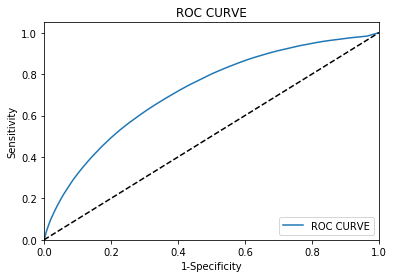

In [27]:
import matplotlib.pylab as plt

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()